# Modelos de Regressão

Os modelos de regressão são largamente utilizados em diversas áreas do conhecimento, tais como: computação, administração, engenharias, biologia, agronomia, saúde, sociologia, etc. O principal objetivo desta técnica é obter uma equação que explique satisfatoriamente a relação entre uma variável resposta e uma ou mais variáveis explicativas, possibilitando fazer predição de valores da variável de interesse. Este relacionamento pode ser por uma equação linear ou uma função não linear, conforme figura abaixo: 

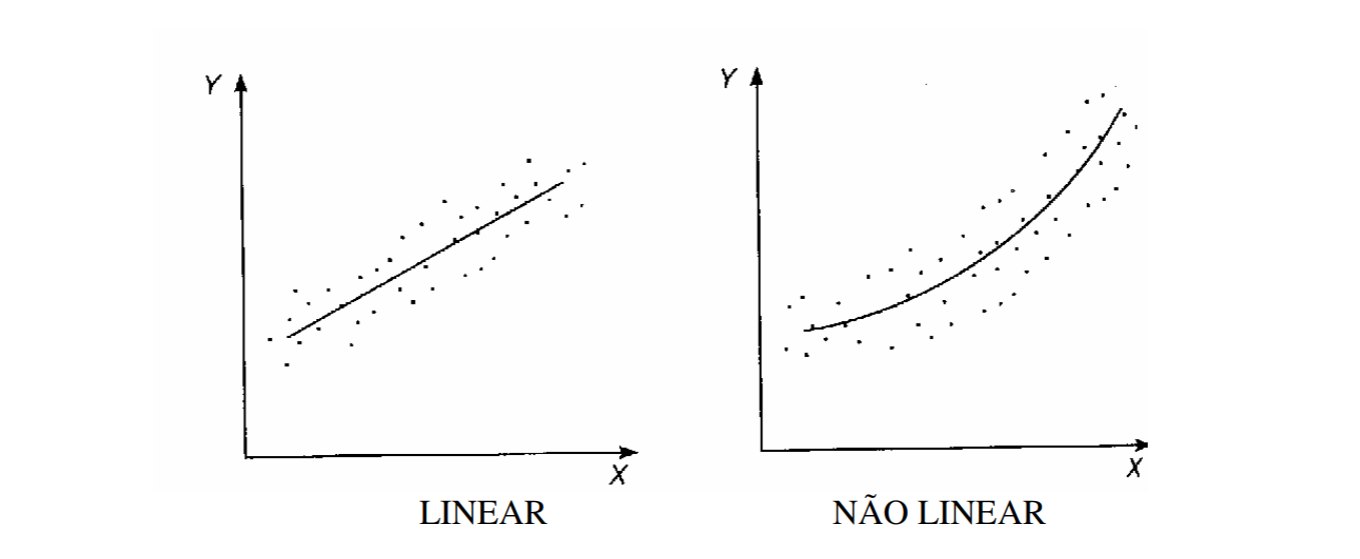

Nessa atividade iremos realizar uma análise do dataset 'IOT-temp.csv' para encontrar realizar predições de temperaturas com regressores baseadas nos dados disponíveis no dataset. Esse dataset apresenta uma leitura de temperaturas internas e externas de um escritório.

<img src="img/modelo_regressao.png" style="width: 800px;"/>

* Análise inicial dos dados
* Filtragem (remoção de ruídos)
* Definindo sequências
* Definindo Target
* Separação dados de treino e teste
* Treinamento do regressor
* Testes e avaliação
* Comparando regressores

# 1. Obtenção e análise inicial dos dados

In [5]:
!pip install matplotlib

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/IOT-temp.csv')
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [7]:
df.drop(['id', 'room_id/id'], axis=1, inplace=True)

<AxesSubplot:>

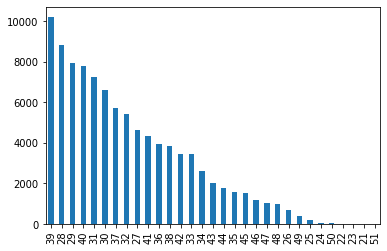

In [8]:
freq = df['temp'].value_counts()
freq.plot.bar()

## 1.1 Separando Temperaturas Internas e Externas

Como visto na **Atividade 2**, precisamos separar o conjunto de dados correspondentes as leituras de temperatura externas e internas pois, esses dados são independentes. Dessa forma, caso análisado juntos podem gerar erros de interpretação (i.e., falsos positivos, falsos negativos)

In [17]:
df_in  = df[df['out/in'] == 'In'].copy()
df_out = df[df['out/in'] == 'Out'].copy()

#drop in/out colunms
df_in.drop('out/in', axis=1, inplace=True)
df_out.drop('out/in', axis=1, inplace=True)


In [18]:
print(f'Len in: {len(df_in)}')
print(f'Len out: {len(df_out)}')

Len in: 20345
Len out: 77261


<AxesSubplot:>

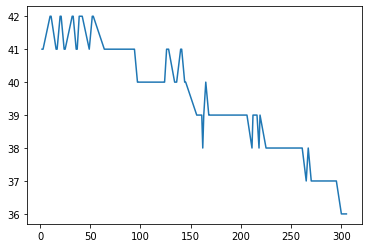

In [19]:
df_out['temp'].iloc[:100].plot()

# 2. Filtragem dos dados

É preciso realizar uma limpeza nos dados para reduzir os ruídos ou variações pequenas dos dados.

<AxesSubplot:>

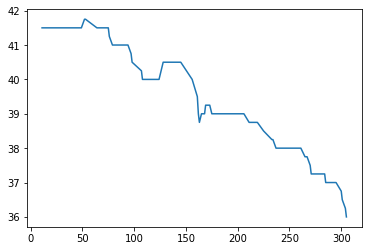

In [20]:
df_out['temp'] = df_out['temp'].rolling(4).mean()
df_out['temp'].iloc[:100].plot()

# 3. Definindo Target

Como a série temporal só possui uma característica (i.e., temp) sem o que deve ser predito a partir dessa temperatura, devemos criar o alvo (i.e., a ser predito pelo modelo de regressão). O **alvo** é definido de acordo com quantos *tempos a frente* queremos predizer. 

**Exemplo:** Caso eu tenha dados de temperatura com granularidade de 1hr e desejo realizar a predição das temperatura para a próxima hora. Devo definir meu alvo como **1 tempo a frente de X**. Para isso, realizador uma rotação de tamanho 1 nos dados X para obter a caracteristica desejada. Como apresentada na figura abaixo

<img src="img/criando_y.png" style="width: 300px;"/>

In [22]:
df_out['Y'] = df_out['temp'].shift(-1)
df_out.dropna(inplace=True)
df_out.tail()

,noted_date,temp,Y
97569,28-07-2018 07:09,32.00,32.25
97570,28-07-2018 07:09,32.25,32.00
97573,28-07-2018 07:08,32.00,32.00
97579,28-07-2018 07:07,32.00,32.00
97580,28-07-2018 07:07,32.00,31.75


# 4. Criando Sequências

<img src="img/sequence.png" style="width: 300px;"/>

In [23]:
tamanho_sequencia = 3

for i in range(tamanho_sequencia):
    df_out[f'temp - {i+1}'] = df_out['temp'].shift(i+1)
    
df_out.dropna(inplace=True)
df_out.head()

,noted_date,temp,Y,temp - 1,temp - 2,temp - 3
20,08-12-2018 09:19,41.5,41.5,41.5,41.5,41.5
21,08-12-2018 09:19,41.5,41.5,41.5,41.5,41.5
24,08-12-2018 09:17,41.5,41.5,41.5,41.5,41.5
25,08-12-2018 09:17,41.5,41.5,41.5,41.5,41.5
32,08-12-2018 09:09,41.5,41.5,41.5,41.5,41.5


## 4.1 Visuzalizando sequencia de dados

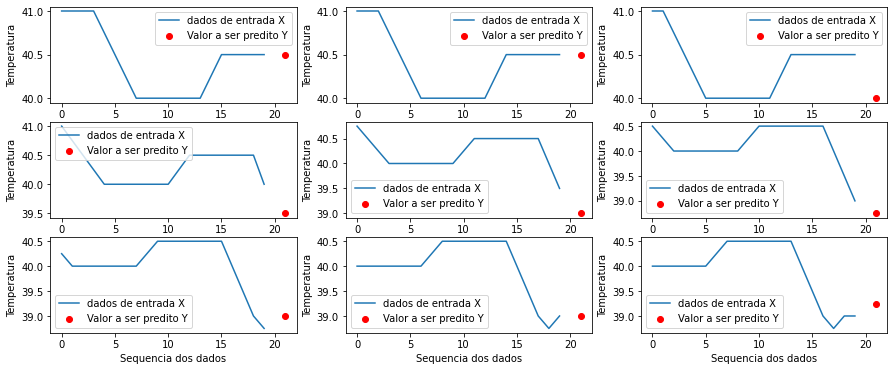

In [27]:
import matplotlib.pyplot as plt
seq      = 20
inicio   = seq

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
for linha in range(3):
    for coluna in range(3):
        x = df_out['temp'].iloc[inicio:inicio + seq]
        y = df_out['temp'].iloc[inicio + seq]
        
        ax[linha, coluna].plot(range(seq), x, label='dados de entrada X')
        ax[linha, coluna].scatter(len(x) + 1, y, label='Valor a ser predito Y', color='r')
        ax[linha, coluna].legend()
        ax[linha, coluna].set_xlabel('Sequencia dos dados')
        ax[linha, coluna].set_ylabel('Temperatura')
        inicio += 1
        


# 5. Separação X e Y

In [28]:
Y = df_out['Y'].values
df_out.drop('Y', axis=1, inplace=True)

noted_date = df_out['noted_date']
df_out.drop('noted_date', axis=1, inplace=True)

X = df_out.values

print(f'Len X: {len(X)}, Len Y: {len(Y)}')

Len X: 77254, Len Y: 77254


## 5.1 Normalização

Para este exemplo iremos realizar a normalização de dados usando o *MinMaxScaler*. O método de uso é o mesmo do *Normalizer()* (normalizador visto na última aula), porém usando o *MinMaxScaler* podemos desfazer a normalização, o que irá facilitar na visualização dos resultados

In [30]:
from sklearn.preprocessing import MinMaxScaler

X_normalizer   = MinMaxScaler()
Y_normalizer   = MinMaxScaler()

X      = X_normalizer.fit_transform(X)
Y      = Y_normalizer.fit_transform(Y.reshape(-1, 1))

Y

array([[0.65979381],
       [0.65979381],
       [0.65979381],
       ...,
       [0.26804124],
       [0.26804124],
       [0.26804124]])

# 6. Separando dados de Treino e Teste

A separação dos dados é importante para realizar o treinamento e avaliação dos modelos de regressão. Entretanto, diferentemente dos classificadores, a sequência dos dados é muito importante para os modelos de regressão. Assim, não é possível utilizar o método *train_test_split*.

Para os modelos de regressão devemos encontrar o indice que indica limite (i.e., a porcentagem de dados para treino) e então realizar a divisão dos dados manualmente.

<img src="img/treino_teste.png" style="width: 600px;"/>

In [31]:
 = int(len(X) *separador 0.8)
print(f'Separador: {separador}')

x_treino = X[ :separador]
y_treino = Y[ :separador]

x_teste  = X[separador: ]
y_teste  = Y[separador: ]

print(f'Len x_teste: {len(x_teste)}, Len y_teste: {len(y_teste)}')

Separador: 61803
Len x_teste: 15451, Len y_teste: 15451


# 7. Treinamento do Regressor

## 7.1 Regressão Linear

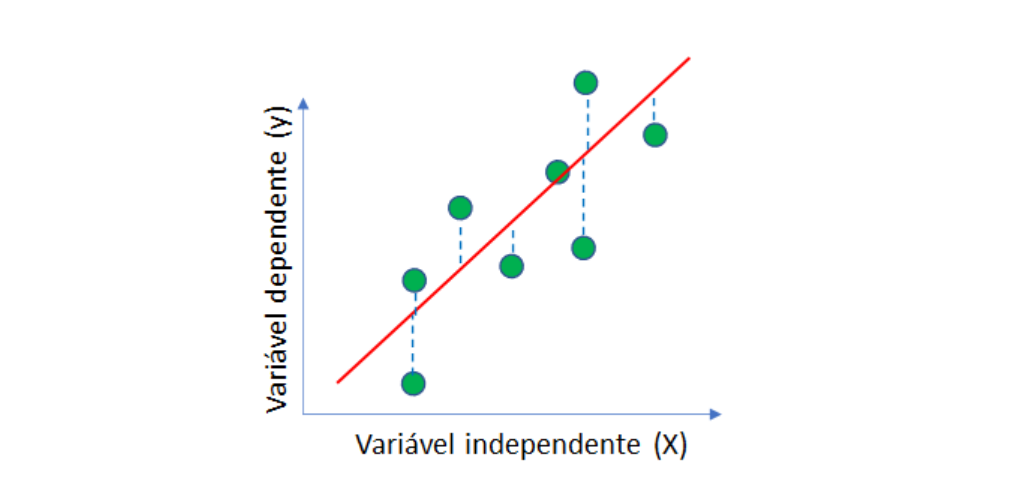

In [34]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_treino, y_treino)

pred_lr = lr.predict(x_teste)
lr.score(x_teste, y_teste)

0.9857877711439912

In [38]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_teste, pred_lr)

4.990838389578802e-05

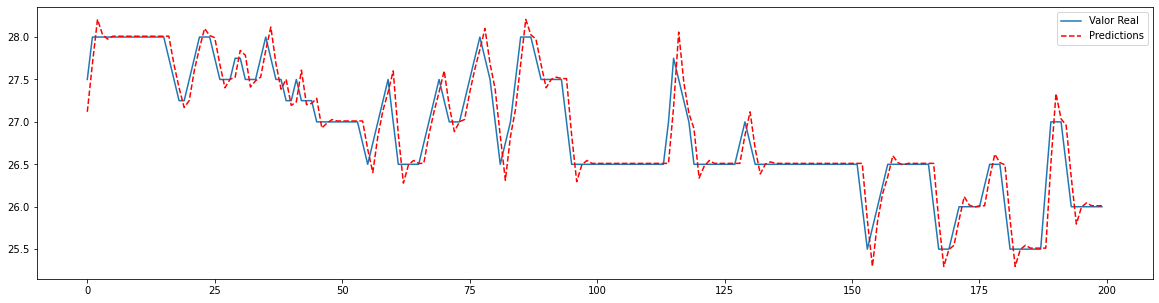

In [42]:
import matplotlib.pyplot as plt
quantidate_predicoes = 200

y_teste_ori = Y_normalizer.inverse_transform(y_teste.reshape(-1, 1))
pred_lr_ori = Y_normalizer.inverse_transform(pred_lr.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(20, 5))
#dates   = noted_date[separador:]
dates   = range(len(y_teste_ori[:quantidate_predicoes]))


ax.plot(dates, y_teste_ori[:quantidate_predicoes], label='Valor Real')
ax.plot(dates, pred_lr_ori[:quantidate_predicoes], label='Predictions', color='r', linestyle='--')
plt.legend()

## Aprimorando visualização

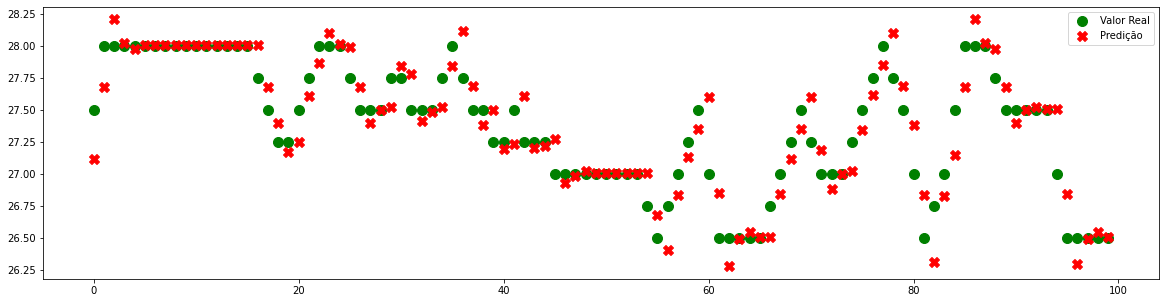

In [44]:
import matplotlib.pyplot as plt
quantidate_predicoes = 100

y_teste_ori = Y_normalizer.inverse_transform(y_teste.reshape(-1, 1))
pred_lr_ori = Y_normalizer.inverse_transform(pred_lr.reshape(-1, 1))
x_teste_ori = X_normalizer.inverse_transform(x_teste)
x_teste_ori = x_teste_ori[1::,0]

fig, ax = plt.subplots(figsize=(20, 5))
#dates   = noted_date[separador:]
dates   = range(len(y_teste_ori[:quantidate_predicoes]))

# ax.plot(dates, x_teste_ori[:quantidate_predicoes], label='Dados Entrada')
ax.scatter(dates, y_teste_ori[:quantidate_predicoes], label='Valor Real', color='g', s=100)
ax.scatter(dates, pred_lr_ori[:quantidate_predicoes], label='Predição', color='r', marker='X', s=100)
plt.legend()

## 7.2 Correlação

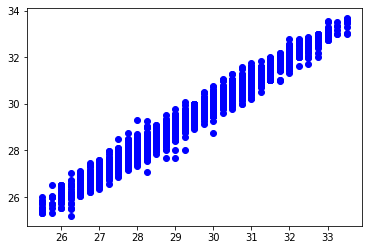

In [41]:
fig, ax = plt.subplots()

ax.scatter(y_teste_ori, pred_lr_ori, color='b')


In [46]:
import numpy as np
max_temp = int(np.max(y_teste_ori) +1)
min_temp = int(np.min(y_teste_ori) -1)

heat_map = np.zeros((max_temp, max_temp))

for i in range(len(y_teste_ori)):
    x = int(y_teste_ori[i])
    y = int(pred_lr_ori[i])
    heat_map[x][y] += 1
    
heat_map

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 555.,  20.,   0.],
       [  0.,   0.,   0., ...,  57., 269.,   5.],
       [  0.,   0.,   0., ...,   0.,  17.,  58.]])

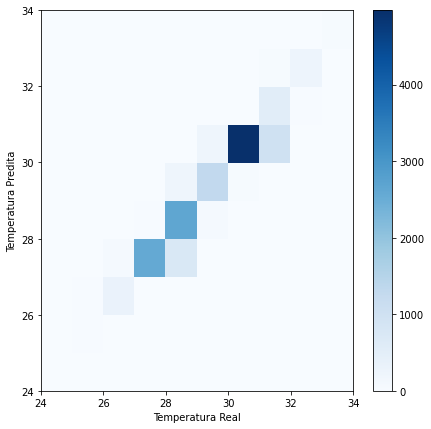

In [47]:
fig, ax = plt.subplots(figsize=(7,7))
psm = ax.pcolormesh(heat_map, cmap='Blues', rasterized=True, )

ax.set_xlim(min_temp, max_temp)
ax.set_ylim(min_temp, max_temp)
ax.set(xlabel='Temperatura Real', ylabel='Temperatura Predita')
fig.colorbar(psm, ax=ax)

# 8. Avaliando Regressores

## 8.1 MSE

**Mean Squared Error (MSE)** é uma métrica que define o erro médio das predições em relação ao valor esperado, onde erros maiores penalizam ainda mais a avaliação por estarem elevado ao quadrado.

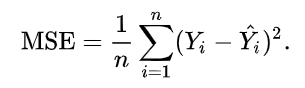

In [44]:
from sklearn.metrics import mean_squared_error

mean_squared_error(pred_lr, y_teste)

4.990838389578802e-05

## 8.2 MAE

**Mean Absolute Error (MAE)** erro médio absoluto, é uma métrica que define a porcentagem média do erro das predições em relação ao valor esperado

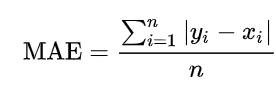

In [45]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(pred_lr, y_teste)

0.004205721136992784

## 8.3 RMSE

**Root Mean Squared Error (RMSE)** é uma métrica que define a distância média do erro em relação ao valor esperado. Entretanto, diferente das outras métricas, o RMSE possui a mesma unidade do valor esperado
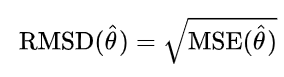

In [99]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(pred_lr_ori, y_teste_ori))

0.1713162251648012

# 9. Comparando Regressores

## 9.1 Regressão Linear

In [49]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_treino, y_treino)
pred_lr = lr.predict(x_teste)
lr.score(x_teste, y_teste)

0.9857877711439912

## 9.2 KNN para Regressão

In [50]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_treino, y_treino)
pred_knn = knn.predict(x_teste) 
knn.score(x_teste, y_teste)

0.9772442077877402

## 9.3 SVM para Regressão

In [51]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(x_treino, y_treino.ravel())
pred_svr = svr.predict(x_teste) 
svr.score(x_teste, y_teste.ravel())

0.6549593148274822

## 9.4 Stochastic Gradient Descent 

In [52]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd.fit(x_treino, y_treino.ravel())
pred_sgd = sgd.predict(x_teste) 
sgd.score(x_teste, y_teste.ravel())

0.9726158053541306

## 9.5 Decision Tree

In [53]:
from sklearn import tree

dt = tree.DecisionTreeRegressor()
dt.fit(x_treino, y_treino)
pred_dt = dt.predict(x_teste) 
dt.score(x_teste, y_teste)

0.9639918316572842

## 9.6 Visualizando resultados

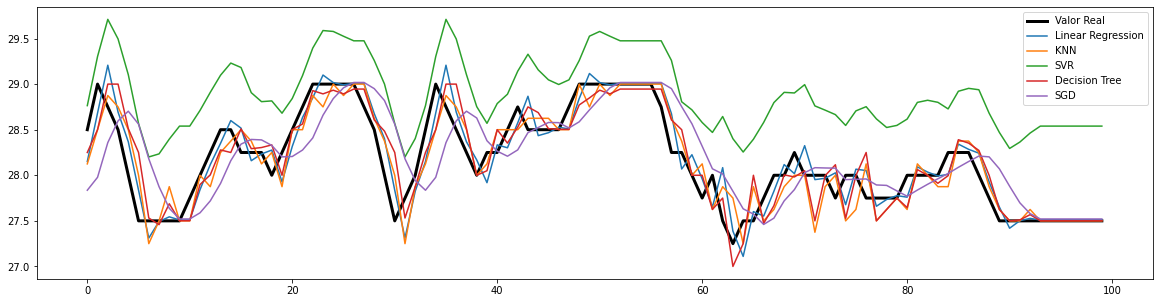

In [61]:
import matplotlib.pyplot as plt
inicio_predicioes    = 2000
quantidate_predicoes = inicio_predicioes + 100

y_teste_ori  = Y_normalizer.inverse_transform(y_teste.reshape(-1, 1))
pred_lr_ori  = Y_normalizer.inverse_transform(pred_lr.reshape(-1, 1))
pred_knn_ori = Y_normalizer.inverse_transform(pred_knn.reshape(-1, 1))
pred_svr_ori = Y_normalizer.inverse_transform(pred_svr.reshape(-1, 1))
pred_dt_ori  = Y_normalizer.inverse_transform(pred_dt.reshape(-1, 1))
pred_sgd_ori = Y_normalizer.inverse_transform(pred_sgd.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(20, 5))
#dates   = noted_date[separador:]
dates   = range(len(y_teste_ori[inicio_predicioes:quantidate_predicoes]))


ax.plot(dates, y_teste_ori[inicio_predicioes:quantidate_predicoes], label='Valor Real', color='k', linewidth=3)
ax.plot(dates, pred_lr_ori[inicio_predicioes:quantidate_predicoes], label='Linear Regression',)
ax.plot(dates, pred_knn_ori[inicio_predicioes:quantidate_predicoes], label='KNN', )
ax.plot(dates, pred_svr_ori[inicio_predicioes:quantidate_predicoes], label='SVR', )
ax.plot(dates, pred_dt_ori[inicio_predicioes:quantidate_predicoes], label='Decision Tree', )
ax.plot(dates, pred_sgd_ori[inicio_predicioes:quantidate_predicoes], label='SGD', )
plt.legend()


In [81]:
rmse_lr  = math.sqrt(mean_squared_error(pred_lr_ori, y_teste_ori))
rmse_knn = math.sqrt(mean_squared_error(pred_knn_ori, y_teste_ori))
rmse_svr = math.sqrt(mean_squared_error(pred_svr_ori, y_teste_ori))
rmse_dt  = math.sqrt(mean_squared_error(pred_dt_ori, y_teste_ori))
rmse_sgd = math.sqrt(mean_squared_error(pred_sgd_ori, y_teste_ori))

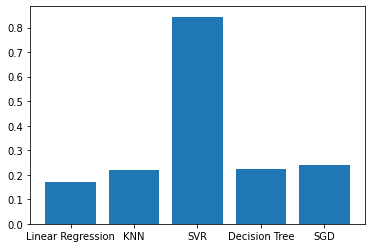

In [82]:
dict_rmse = {
    'Linear Regression' : rmse_lr,
    'KNN'               : rmse_knn,
    'SVR'               : rmse_svr,
    'Decision Tree'     : rmse_dt,
    'SGD'               : rmse_sgd
}

plt.bar(dict_rmse.keys(), dict_rmse.values())
plt.show()